In [5]:
import sys

COMMON_DIR = "/mnt/d/github/computer_vision/books/generative_deep_learning/pytorch/common"
if COMMON_DIR not in sys.path:
    sys.path.append(COMMON_DIR)

from common.datasets import get_train_loader, get_test_loader
from common.utils import set_seed, plot_images, create_images
from common.trainer import fit, evaluate, predict

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as T

In [7]:
IMAGE_SIZE = 32
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 128
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

In [8]:
### Data Loading
from common.datasets import CelebA

root_dir = "/mnt/d/datasets/celeba"
transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=T.InterpolationMode.BILINEAR),
    T.ToTensor(),
])

train_loader = get_train_loader(dataset=CelebA(root_dir, "train", transform=transform), batch_size=BATCH_SIZE)
valid_loader = get_test_loader(dataset=CelebA(root_dir, "valid", transform=transform), batch_size=32)
test_loader = get_test_loader(dataset=CelebA(root_dir, "test", transform=transform), batch_size=32)

batch = next(iter(train_loader))
images, labels = batch["image"], batch["label"]
print(f"\ntrain dataset: {len(train_loader.dataset)}, dataloader: {len(train_loader)}")
print(f"train images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"train labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")

batch = next(iter(valid_loader))
images, labels = batch["image"], batch["label"]
print(f"\nvalid dataset: {len(valid_loader.dataset)}, dataloader: {len(valid_loader)}")
print(f"valid images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"valid labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")

batch = next(iter(test_loader))
images, labels = batch["image"], batch["label"]
print(f"\ntest dataset: {len(test_loader.dataset)}, dataloader: {len(test_loader)}")
print(f"test  images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"test  labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")


train dataset: 162770, dataloader: 1271
train images: torch.Size([128, 3, 32, 32]), torch.float32, 0.0, 1.0
train labels: torch.Size([128]), torch.int64, 0, 1

valid dataset: 19867, dataloader: 621
valid images: torch.Size([32, 3, 32, 32]), torch.float32, 0.0, 1.0
valid labels: torch.Size([32]), torch.int64, 0, 1

test dataset: 19962, dataloader: 624
test  images: torch.Size([32, 3, 32, 32]), torch.float32, 0.0, 1.0
test  labels: torch.Size([32]), torch.int64, 0, 1


In [9]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=Z_DIM, in_channels=CHANNELS):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2)
        )
        self.flatten_size = NUM_FEATURES * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16)
        self.fc1 = nn.Linear(self.flatten_size, latent_dim)
        self.fc2 = nn.Linear(self.flatten_size, latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(mu)
        return mu + std * eps

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, self.flatten_size)
        mu, logvar = self.fc1(x), self.fc2(x)
        latent = self.reparameterize(mu, logvar)
        return latent, mu, logvar

In [10]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=Z_DIM, out_channels=CHANNELS):
        super().__init__()

        self.flatten_size = NUM_FEATURES * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16)
        self.fc = nn.Linear(latent_dim, self.flatten_size)
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2)
        )
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2)
        )
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2)
        )
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2)
        )
        self.deconv5 = nn.ConvTranspose2d(NUM_FEATURES, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, NUM_FEATURES, IMAGE_SIZE // 16, IMAGE_SIZE // 16)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv5(x)
        x = torch.sigmoid(x)
        return x

In [13]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder, beta=500, device=None):
        super().__init__()
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder = encoder.to(self.device)
        self.decoder = decoder.to(self.device)
        self.beta = beta
        self.bce_loss = nn.BCELoss(reduction='none')
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, images):
        latent, mu, logvar = self.encoder(images)
        recon = self.decoder(latent)
        return recon, latent, mu, logvar

    def loss_fn(self, recon, images, mu, logvar):
        bce_pixel = self.bce_loss(recon, images)
        bce = bce_pixel.view(bce_pixel.size(0), -1).mean(dim=1)    # (B,)
        bce = self.beta * bce.mean() 

        kld_sample = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)  # (B,)
        kld = kld_sample.mean()

        loss =  bce + kld
        return loss, bce, kld

    def train_step(self, batch):
        images = batch["image"].to(self.device)
        self.optimizer.zero_grad()
        recon, latent, mu, logvar = self.forward(images)
        loss, bce, kld = self.loss_fn(recon, images, mu, logvar)
        loss.backward()
        self.optimizer.step()
        return dict(loss=loss, bce=bce, kld=kld)

    @torch.no_grad()
    def eval_step(self, batch):
        images = batch["image"].to(self.device)
        recon, latent, mu, logvar = self.forward(images)
        loss, bce, kld = self.loss_fn(recon, images, mu, logvar)
        return dict(loss=loss, bce=bce, kld=kld)

    @torch.no_grad()
    def pred_step(self, batch):
        images = batch["image"].to(self.device)
        labels = batch["label"]
        recon, latent, mu, logvar = self.forward(images)
        return dict(image=images, label=labels, latent=latent, recon=recon)

In [15]:
encoder = Encoder(latent_dim=200, in_channels=3)
decoder = Decoder(latent_dim=200, out_channels=3)
model = VAE(encoder, decoder)

history = fit(model, train_loader, num_epochs=10, valid_loader=test_loader)

[  1/10] loss:296.563, bce:286.487, kld:10.076 | (val) loss:286.170, bce:274.828, kld:11.341      
[  2/10] loss:286.695, bce:275.385, kld:11.310 | (val) loss:284.686, bce:273.121, kld:11.565       
[  3/10] loss:285.751, bce:274.243, kld:11.508 | (val) loss:284.084, bce:272.543, kld:11.541      
[  4/10] loss:285.163, bce:273.375, kld:11.788 | (val) loss:283.476, bce:271.460, kld:12.016      
[  5/10] loss:284.840, bce:272.886, kld:11.954 | (val) loss:283.213, bce:271.331, kld:11.882      
[  6/10] loss:284.571, bce:272.488, kld:12.084 | (val) loss:283.205, bce:271.063, kld:12.142      
[  7/10] loss:284.391, bce:272.245, kld:12.147 | (val) loss:282.965, bce:270.866, kld:12.099      
[  8/10] loss:284.233, bce:272.063, kld:12.170 | (val) loss:282.769, bce:270.693, kld:12.077       
[  9/10] loss:284.155, bce:271.956, kld:12.199 | (val) loss:282.741, bce:270.511, kld:12.229      
[ 10/10] loss:284.058, bce:271.817, kld:12.240 | (val) loss:282.647, bce:270.542, kld:12.105       


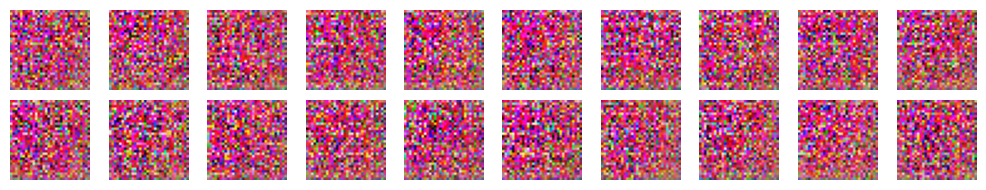

[  1/5] loss:295.519, bce:285.229, kld:10.290                                                    
[  2/5] loss:286.917, bce:275.779, kld:11.138                                                    
[  3/5] loss:285.608, bce:274.026, kld:11.582                                                    
[  4/5] loss:285.074, bce:273.232, kld:11.842                                                    
[  5/5] loss:284.783, bce:272.877, kld:11.906                                                    


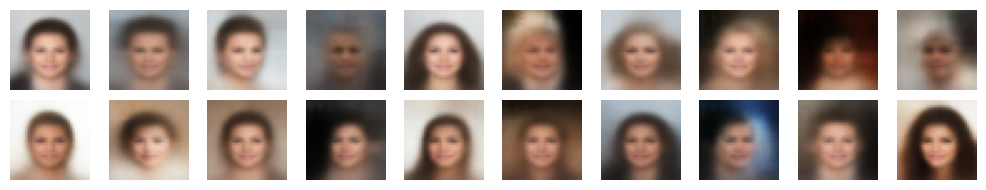

[  1/5] loss:284.546, bce:272.480, kld:12.066                                                    
[  2/5] loss:284.394, bce:272.256, kld:12.138                                                    
[  3/5] loss:284.234, bce:272.077, kld:12.157                                                    
[  4/5] loss:284.169, bce:271.965, kld:12.204                                                    
[  5/5] loss:284.035, bce:271.818, kld:12.218                                                    


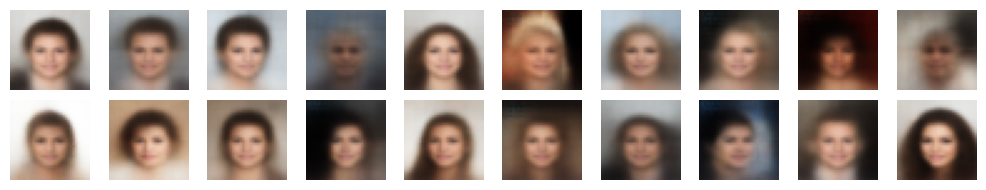

[  1/5] loss:283.986, bce:271.759, kld:12.227                                                    


KeyboardInterrupt: 

In [16]:
encoder = Encoder(latent_dim=200, in_channels=3)
decoder = Decoder(latent_dim=200, out_channels=3)
model = VAE(encoder, decoder)

z_sample = np.random.normal(size=(20, 200))
total_history = {}
images = create_images(decoder, z_sample)
plot_images(*images, ncols=10, xunit=1, yunit=1)

for _ in range(5):
    history = fit(model, train_loader, num_epochs=5)
    for split_name, metrics in history.items():
        total_history.setdefault(split_name, {})
        for metric_name, metric_values in metrics.items():
            total_history[split_name].setdefault(metric_name, [])
            total_history[split_name][metric_name].extend(metric_values)

    images = create_images(decoder, z_sample)
    plot_images(*images, ncols=10, xunit=1, yunit=1)

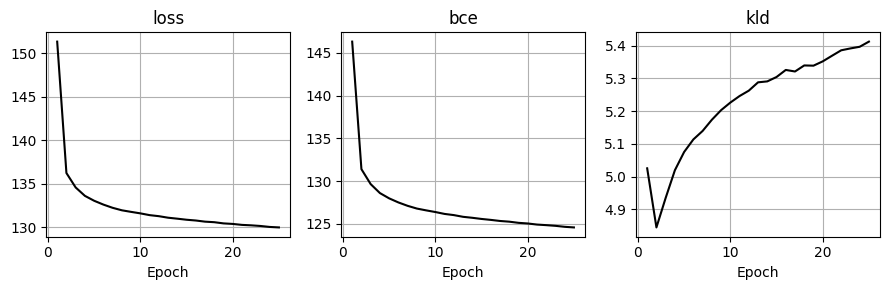

In [ ]:
from common.utils import plot_history

plot_history(total_history["train"])